# COMP 8610: Assignment 2

Spencer Briguglio&nbsp;103 746 720</br>
Nour Elkot&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;104 982 352</br>
Karan Vishavjit&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;110 099 867

## Question 1
### Prepare the Data

In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import logging

# Set random seed
np.random.seed = 7

In [5]:
# Generate 5000 synthetic data points (x,y)
# Vector X
X_mu = 0
X_std = 1
X_ = np.random.normal(X_mu, X_std, size=(5000,1))

# Vector Eps
eps_mu = 0
eps_std = np.sqrt(0.25)
eps_ = np.random.normal(eps_mu, eps_std, size=(5000,1))

# Generate the Y vector
Y_ = np.zeros(shape=(1,5000))
Y_ = -1 + (0.5 * X_) - (2 * X_**2) + (0.3 * X_**3) + eps_

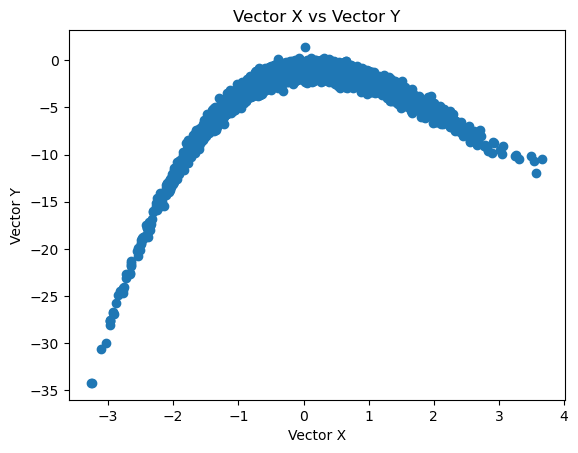

In [6]:
# Y vs X Scatterplot
plt.scatter(X_, Y_)

plt.title("Vector X vs Vector Y")
plt.xlabel("Vector X")
plt.ylabel("Vector Y")
plt.show()

## Adaline Neuron

In [15]:
# Define Neuron
class neuron:
    def __init__(self, mode="adaline", descent_method="sgd"):
        logger = logging.getLogger(__name__)
        # Check parameters
        try:
            if mode != "adaline" and mode != "sigmoid":
                raise ValueError("Invalid mode, \"{}\", passed to neuron class. Expected \"adaline\" or \"sigmoid\".".format(mode))
            elif descent_method != "sgd" and descent_method != "bgd":
                raise ValueError("Invalid gradient descent method, \"{}\", passed to neuron class. Expected \"sgd\" or \"sigmoid\".".format(descent_method))
            
            self.mode = mode
            self.descent_method = descent_method
        except ValueError as error:
            logger.error(error)
            raise
            

In [17]:
n = neuron(mode="adaline", descent_method="bgd")